# XGBoost Model for Student Exam Score Prediction

This notebook builds an XGBoost regression model to predict student exam scores based on various factors including study habits, attendance, parental involvement, and more.

## Contents:
1. Data Loading & Exploration
2. Feature Understanding & Preprocessing
3. XGBoost Model Training
4. Hyperparameter Tuning
5. Cross-Validation
6. Feature Importance Analysis
7. Final Model Evaluation

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading & Exploration

Load the raw dataset and understand its structure, features, and target variable.

In [2]:
# Load the raw dataset
df = pd.read_csv('../../Data/Raw/StudentPerformanceFactors.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\n" + "="*50)
print("First 5 rows:")
df.head()

Dataset Shape: (6607, 20)

First 5 rows:


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [3]:
# Dataset info and statistics
print("Data Types:")
print(df.dtypes)
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nBasic Statistics:")
df.describe()

Data Types:
Hours_Studied                  int64
Attendance                     int64
Parental_Involvement          object
Access_to_Resources           object
Extracurricular_Activities    object
Sleep_Hours                    int64
Previous_Scores                int64
Motivation_Level              object
Internet_Access               object
Tutoring_Sessions              int64
Family_Income                 object
Teacher_Quality               object
School_Type                   object
Peer_Influence                object
Physical_Activity              int64
Learning_Disabilities         object
Parental_Education_Level      object
Distance_from_Home            object
Gender                        object
Exam_Score                     int64
dtype: object


Missing Values:
Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores   

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


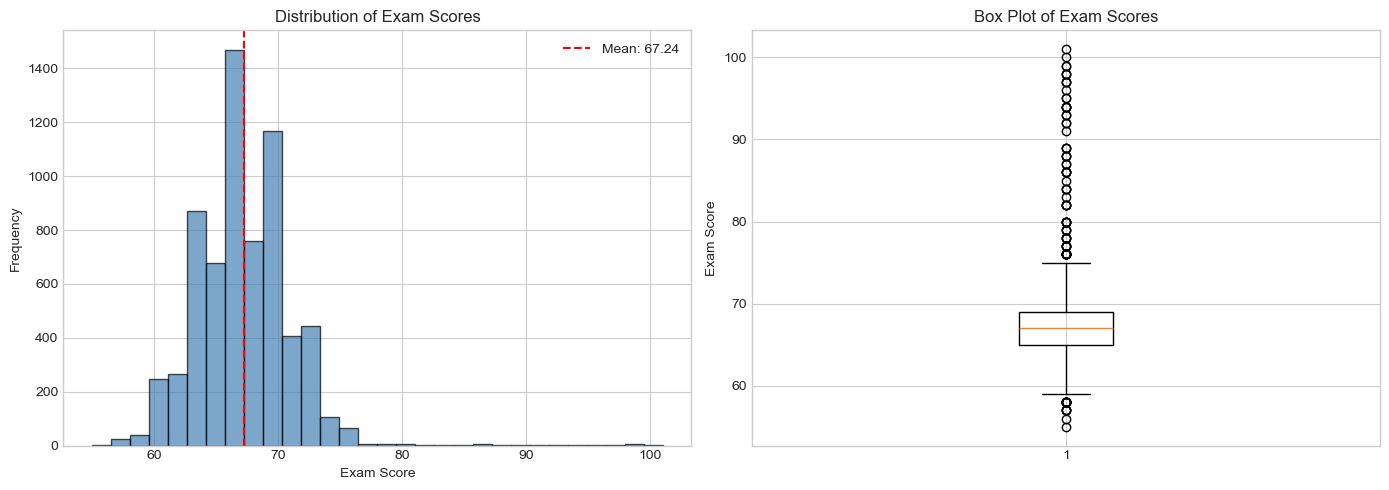

Target Statistics:
  Mean: 67.24
  Std: 3.89
  Min: 55
  Max: 101


In [4]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['Exam_Score'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Exam Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Exam Scores')
axes[0].axvline(df['Exam_Score'].mean(), color='red', linestyle='--', label=f'Mean: {df["Exam_Score"].mean():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df['Exam_Score'], vert=True)
axes[1].set_ylabel('Exam Score')
axes[1].set_title('Box Plot of Exam Scores')

plt.tight_layout()
plt.show()

print(f"Target Statistics:")
print(f"  Mean: {df['Exam_Score'].mean():.2f}")
print(f"  Std: {df['Exam_Score'].std():.2f}")
print(f"  Min: {df['Exam_Score'].min()}")
print(f"  Max: {df['Exam_Score'].max()}")

## 2. Feature Understanding & Preprocessing

Identify categorical and numerical features, handle missing values, and encode categorical variables.

In [5]:
# Identify feature types
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target from numerical columns
numerical_cols.remove('Exam_Score')

print("Numerical Features:")
print(numerical_cols)
print(f"\nCategorical Features:")
print(categorical_cols)

# Display unique values for categorical features
print("\n" + "="*50)
print("Unique values in categorical features:")
for col in categorical_cols:
    print(f"\n{col}: {df[col].unique()}")

Numerical Features:
['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']

Categorical Features:
['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']

Unique values in categorical features:

Parental_Involvement: ['Low' 'Medium' 'High']

Access_to_Resources: ['High' 'Medium' 'Low']

Extracurricular_Activities: ['No' 'Yes']

Motivation_Level: ['Low' 'Medium' 'High']

Internet_Access: ['Yes' 'No']

Family_Income: ['Low' 'Medium' 'High']

Teacher_Quality: ['Medium' 'High' 'Low' nan]

School_Type: ['Public' 'Private']

Peer_Influence: ['Positive' 'Negative' 'Neutral']

Learning_Disabilities: ['No' 'Yes']

Parental_Education_Level: ['High School' 'College' 'Postgraduate' nan]

Distance_from_Home: ['Near' 'Moderate' 'Far' na

In [9]:
# Handle missing values
print("Handling missing values...")

# Fill missing categorical values with mode
for col in ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)
    print(f"  {col}: filled with '{mode_val}'")

print("\nMissing values after handling:")
print(df.isnull().sum().sum())

Handling missing values...
  Teacher_Quality: filled with 'Medium'
  Parental_Education_Level: filled with 'High School'
  Distance_from_Home: filled with 'Near'

Missing values after handling:
0


In [10]:
# Create a copy for preprocessing
df_processed = df.copy()

# Encode ordinal categorical variables
ordinal_mappings = {
    'Parental_Involvement': {'Low': 0, 'Medium': 1, 'High': 2},
    'Access_to_Resources': {'Low': 0, 'Medium': 1, 'High': 2},
    'Motivation_Level': {'Low': 0, 'Medium': 1, 'High': 2},
    'Family_Income': {'Low': 0, 'Medium': 1, 'High': 2},
    'Teacher_Quality': {'Low': 0, 'Medium': 1, 'High': 2},
    'Peer_Influence': {'Negative': 0, 'Neutral': 1, 'Positive': 2},
    'Parental_Education_Level': {'High School': 0, 'College': 1, 'Postgraduate': 2},
    'Distance_from_Home': {'Far': 0, 'Moderate': 1, 'Near': 2}
}

for col, mapping in ordinal_mappings.items():
    df_processed[col] = df_processed[col].map(mapping)

# Encode binary categorical variables
binary_cols = ['Extracurricular_Activities', 'Internet_Access', 'Learning_Disabilities', 'School_Type', 'Gender']
binary_mappings = {
    'Extracurricular_Activities': {'No': 0, 'Yes': 1},
    'Internet_Access': {'No': 0, 'Yes': 1},
    'Learning_Disabilities': {'No': 0, 'Yes': 1},
    'School_Type': {'Private': 0, 'Public': 1},
    'Gender': {'Female': 0, 'Male': 1}
}

for col, mapping in binary_mappings.items():
    df_processed[col] = df_processed[col].map(mapping)

print("Encoded dataset preview:")
df_processed.head()

Encoded dataset preview:


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,0,2,0,7,73,0,1,0,0,1,1,2,3,0,0,2,1,67
1,19,64,0,1,0,8,59,0,1,2,1,1,1,0,4,0,1,1,0,61
2,24,98,1,1,1,7,91,1,1,2,1,1,1,1,4,0,2,2,1,74
3,29,89,0,1,1,8,98,1,1,1,1,1,1,0,4,0,0,1,1,71
4,19,92,1,1,1,6,65,1,1,3,1,2,1,1,4,0,1,2,0,70


In [11]:
# Prepare features and target
X = df_processed.drop('Exam_Score', axis=1)
y = df_processed['Exam_Score']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nFeatures: {X.columns.tolist()}")

Training set size: 5285
Test set size: 1322

Features: ['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']


## 3. Baseline XGBoost Model

Train an initial XGBoost model with default parameters to establish a baseline performance.

In [12]:
# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """Evaluate model and print metrics"""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Train R²': r2_score(y_train, y_train_pred),
        'Test R²': r2_score(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
    }
    
    print(f"\n{'='*50}")
    print(f"{model_name} Performance Metrics")
    print(f"{'='*50}")
    print(f"\n{'Metric':<15} {'Train':<15} {'Test':<15}")
    print(f"{'-'*45}")
    print(f"{'R²':<15} {metrics['Train R²']:<15.4f} {metrics['Test R²']:<15.4f}")
    print(f"{'MAE':<15} {metrics['Train MAE']:<15.4f} {metrics['Test MAE']:<15.4f}")
    print(f"{'RMSE':<15} {metrics['Train RMSE']:<15.4f} {metrics['Test RMSE']:<15.4f}")
    
    return metrics, y_test_pred

In [13]:
# Train baseline XGBoost model
baseline_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)

# Evaluate baseline model
baseline_metrics, baseline_pred = evaluate_model(
    baseline_model, X_train, X_test, y_train, y_test, 
    "Baseline XGBoost"
)


Baseline XGBoost Performance Metrics

Metric          Train           Test           
---------------------------------------------
R²              0.9750          0.6494         
MAE             0.3435          0.9864         
RMSE            0.6196          2.2261         


## 4. Cross-Validation

Perform k-fold cross-validation to get a more robust estimate of model performance.

In [14]:
# Perform 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores for different metrics
cv_r2 = cross_val_score(baseline_model, X, y, cv=kfold, scoring='r2')
cv_neg_mae = cross_val_score(baseline_model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
cv_neg_rmse = cross_val_score(baseline_model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')

print("5-Fold Cross-Validation Results (Baseline Model)")
print("="*50)
print(f"\nR² Score:")
print(f"  Scores per fold: {cv_r2}")
print(f"  Mean: {cv_r2.mean():.4f} (+/- {cv_r2.std() * 2:.4f})")

print(f"\nMAE:")
print(f"  Scores per fold: {-cv_neg_mae}")
print(f"  Mean: {-cv_neg_mae.mean():.4f} (+/- {cv_neg_mae.std() * 2:.4f})")

print(f"\nRMSE:")
print(f"  Scores per fold: {-cv_neg_rmse}")
print(f"  Mean: {-cv_neg_rmse.mean():.4f} (+/- {cv_neg_rmse.std() * 2:.4f})")

5-Fold Cross-Validation Results (Baseline Model)

R² Score:
  Scores per fold: [0.64940739 0.65570283 0.7546705  0.62202048 0.52421832]
  Mean: 0.6412 (+/- 0.1475)

MAE:
  Scores per fold: [0.98644769 0.97001421 0.94341785 0.99525708 1.01293063]
  Mean: 0.9816 (+/- 0.0472)

RMSE:
  Scores per fold: [2.22612953 2.18107533 1.74742627 2.58831382 2.88493085]
  Mean: 2.3256 (+/- 0.7730)


## 5. Hyperparameter Tuning

Use GridSearchCV to find optimal hyperparameters for the XGBoost model.

In [15]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# First, do a coarse search with fewer combinations
param_grid_coarse = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print("Starting GridSearchCV (coarse search)...")
print(f"Number of parameter combinations: {np.prod([len(v) for v in param_grid_coarse.values()])}")

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_coarse,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest CV RMSE: {-grid_search.best_score_:.4f}")

Starting GridSearchCV (coarse search)...
Number of parameter combinations: 144
Fitting 3 folds for each of 144 candidates, totalling 432 fits

Best parameters found:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}

Best CV RMSE: 2.1620


In [16]:
# Fine-tune around the best parameters
best_params = grid_search.best_params_

# Create refined parameter grid
param_grid_fine = {
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50],
    'max_depth': [max(1, best_params['max_depth'] - 1), best_params['max_depth'], best_params['max_depth'] + 1],
    'learning_rate': [best_params['learning_rate'] * 0.5, best_params['learning_rate'], best_params['learning_rate'] * 1.5],
    'min_child_weight': [best_params['min_child_weight']],
    'subsample': [best_params['subsample']],
    'colsample_bytree': [best_params['colsample_bytree']],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

print("Starting fine-tuning GridSearchCV...")

grid_search_fine = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_grid=param_grid_fine,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search_fine.fit(X_train, y_train)

print("\nBest parameters after fine-tuning:")
print(grid_search_fine.best_params_)
print(f"\nBest CV RMSE: {-grid_search_fine.best_score_:.4f}")

Starting fine-tuning GridSearchCV...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best parameters after fine-tuning:
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 2, 'subsample': 0.8}

Best CV RMSE: 2.0999


In [17]:
# Train the optimized model
best_model = grid_search_fine.best_estimator_

# Evaluate optimized model
optimized_metrics, optimized_pred = evaluate_model(
    best_model, X_train, X_test, y_train, y_test, 
    "Optimized XGBoost"
)

# Compare baseline vs optimized
print("\n" + "="*50)
print("Performance Comparison: Baseline vs Optimized")
print("="*50)
print(f"\n{'Metric':<15} {'Baseline':<15} {'Optimized':<15} {'Improvement':<15}")
print(f"{'-'*60}")
print(f"{'Test R²':<15} {baseline_metrics['Test R²']:<15.4f} {optimized_metrics['Test R²']:<15.4f} {(optimized_metrics['Test R²'] - baseline_metrics['Test R²'])*100:+.2f}%")
print(f"{'Test MAE':<15} {baseline_metrics['Test MAE']:<15.4f} {optimized_metrics['Test MAE']:<15.4f} {(baseline_metrics['Test MAE'] - optimized_metrics['Test MAE']):+.4f}")
print(f"{'Test RMSE':<15} {baseline_metrics['Test RMSE']:<15.4f} {optimized_metrics['Test RMSE']:<15.4f} {(baseline_metrics['Test RMSE'] - optimized_metrics['Test RMSE']):+.4f}")


Optimized XGBoost Performance Metrics

Metric          Train           Test           
---------------------------------------------
R²              0.7410          0.7578         
MAE             0.6024          0.6139         
RMSE            1.9959          1.8501         

Performance Comparison: Baseline vs Optimized

Metric          Baseline        Optimized       Improvement    
------------------------------------------------------------
Test R²         0.6494          0.7578          +10.84%
Test MAE        0.9864          0.6139          +0.3726
Test RMSE       2.2261          1.8501          +0.3760


In [18]:
# Cross-validation on optimized model
cv_r2_opt = cross_val_score(best_model, X, y, cv=kfold, scoring='r2')
cv_neg_mae_opt = cross_val_score(best_model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
cv_neg_rmse_opt = cross_val_score(best_model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')

print("5-Fold Cross-Validation Results (Optimized Model)")
print("="*50)
print(f"\nR² Score:")
print(f"  Scores per fold: {cv_r2_opt}")
print(f"  Mean: {cv_r2_opt.mean():.4f} (+/- {cv_r2_opt.std() * 2:.4f})")

print(f"\nMAE:")
print(f"  Scores per fold: {-cv_neg_mae_opt}")
print(f"  Mean: {-cv_neg_mae_opt.mean():.4f} (+/- {cv_neg_mae_opt.std() * 2:.4f})")

print(f"\nRMSE:")
print(f"  Scores per fold: {-cv_neg_rmse_opt}")
print(f"  Mean: {-cv_neg_rmse_opt.mean():.4f} (+/- {cv_neg_rmse_opt.std() * 2:.4f})")

# Compare cross-validation results
print("\n" + "="*50)
print("Cross-Validation Comparison")
print("="*50)
print(f"\n{'Metric':<10} {'Baseline Mean':<18} {'Optimized Mean':<18}")
print(f"{'-'*50}")
print(f"{'R²':<10} {cv_r2.mean():<18.4f} {cv_r2_opt.mean():<18.4f}")
print(f"{'MAE':<10} {-cv_neg_mae.mean():<18.4f} {-cv_neg_mae_opt.mean():<18.4f}")
print(f"{'RMSE':<10} {-cv_neg_rmse.mean():<18.4f} {-cv_neg_rmse_opt.mean():<18.4f}")

5-Fold Cross-Validation Results (Optimized Model)

R² Score:
  Scores per fold: [0.75615203 0.73131329 0.8809461  0.67194819 0.57424325]
  Mean: 0.7229 (+/- 0.2017)

MAE:
  Scores per fold: [0.61334836 0.62362701 0.54446715 0.68407434 0.70052594]
  Mean: 0.6332 (+/- 0.1113)

RMSE:
  Scores per fold: [1.8565582  1.92675722 1.21729493 2.41131544 2.72905517]
  Mean: 2.0282 (+/- 1.0336)

Cross-Validation Comparison

Metric     Baseline Mean      Optimized Mean    
--------------------------------------------------
R²         0.6412             0.7229            
MAE        0.9816             0.6332            
RMSE       2.3256             2.0282            


## 6. Feature Importance Analysis

Analyze which features have the most impact on exam score prediction.

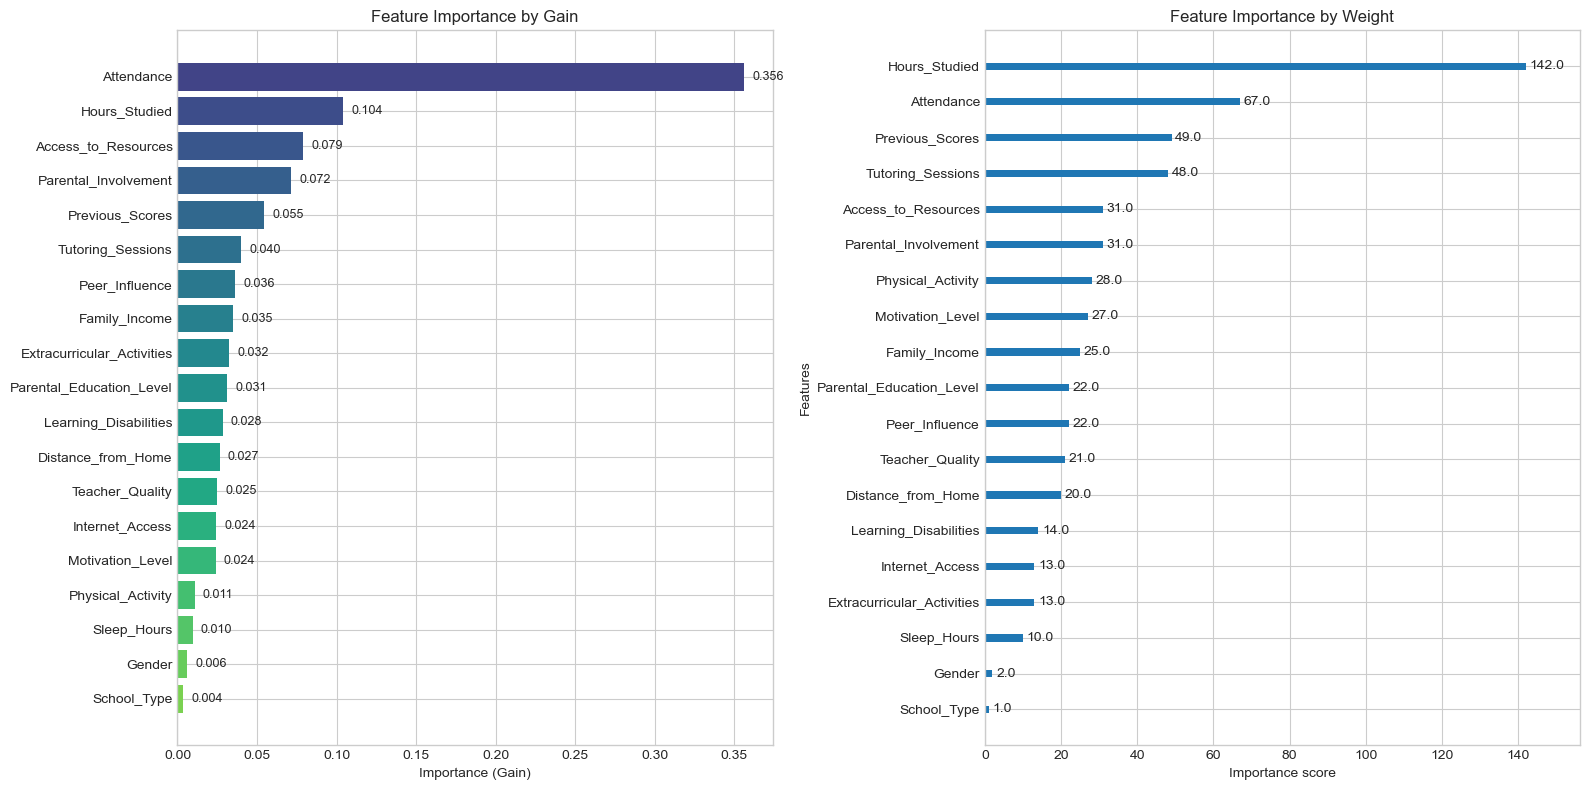


Feature Importance Rankings:
                   Feature     Gain
                Attendance 0.356261
             Hours_Studied 0.104203
       Access_to_Resources 0.079041
      Parental_Involvement 0.071618
           Previous_Scores 0.054574
         Tutoring_Sessions 0.040144
            Peer_Influence 0.036233
             Family_Income 0.035024
Extracurricular_Activities 0.032427
  Parental_Education_Level 0.031386
     Learning_Disabilities 0.028467
        Distance_from_Home 0.026612
           Teacher_Quality 0.025041
           Internet_Access 0.024331
          Motivation_Level 0.024174
         Physical_Activity 0.010731
               Sleep_Hours 0.009741
                    Gender 0.006217
               School_Type 0.003776


In [19]:
# Get feature importance (multiple types)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Gain': best_model.feature_importances_
}).sort_values('Gain', ascending=False)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar plot of feature importance by gain
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance)))
bars = ax1.barh(feature_importance['Feature'], feature_importance['Gain'], color=colors)
ax1.set_xlabel('Importance (Gain)')
ax1.set_title('Feature Importance by Gain')
ax1.invert_yaxis()

# Add value labels
for bar, val in zip(bars, feature_importance['Gain']):
    ax1.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', fontsize=9)

# XGBoost built-in plot
ax2 = axes[1]
xgb.plot_importance(best_model, ax=ax2, importance_type='weight', 
                    title='Feature Importance by Weight', show_values=True)

plt.tight_layout()
plt.show()

# Print feature importance table
print("\nFeature Importance Rankings:")
print("="*50)
print(feature_importance.to_string(index=False))

In [20]:
# Feature importance interpretation
print("\n" + "="*60)
print("Feature Importance Interpretation")
print("="*60)

top_features = feature_importance.head(5)['Feature'].tolist()
print(f"\nTop 5 Most Important Features:")
for i, feat in enumerate(top_features, 1):
    importance = feature_importance[feature_importance['Feature'] == feat]['Gain'].values[0]
    print(f"  {i}. {feat}: {importance:.4f}")

print("\nInterpretation:")
print("-" * 60)
interpretations = {
    'Hours_Studied': 'More study hours strongly correlate with higher exam scores',
    'Attendance': 'Regular class attendance is crucial for academic success',
    'Previous_Scores': 'Past performance is a strong predictor of future results',
    'Tutoring_Sessions': 'Additional tutoring support improves performance',
    'Parental_Involvement': 'Active parental engagement benefits student outcomes',
    'Sleep_Hours': 'Adequate sleep affects cognitive performance',
    'Motivation_Level': 'Student motivation drives academic achievement',
    'Teacher_Quality': 'Quality teaching impacts learning outcomes',
    'Access_to_Resources': 'Educational resources availability matters',
    'Physical_Activity': 'Physical health supports mental performance'
}

for feat in top_features:
    if feat in interpretations:
        print(f"• {feat}: {interpretations[feat]}")


Feature Importance Interpretation

Top 5 Most Important Features:
  1. Attendance: 0.3563
  2. Hours_Studied: 0.1042
  3. Access_to_Resources: 0.0790
  4. Parental_Involvement: 0.0716
  5. Previous_Scores: 0.0546

Interpretation:
------------------------------------------------------------
• Attendance: Regular class attendance is crucial for academic success
• Hours_Studied: More study hours strongly correlate with higher exam scores
• Access_to_Resources: Educational resources availability matters
• Parental_Involvement: Active parental engagement benefits student outcomes
• Previous_Scores: Past performance is a strong predictor of future results


## 7. Final Model Evaluation & Visualization

Comprehensive evaluation of the final optimized model with visualizations.

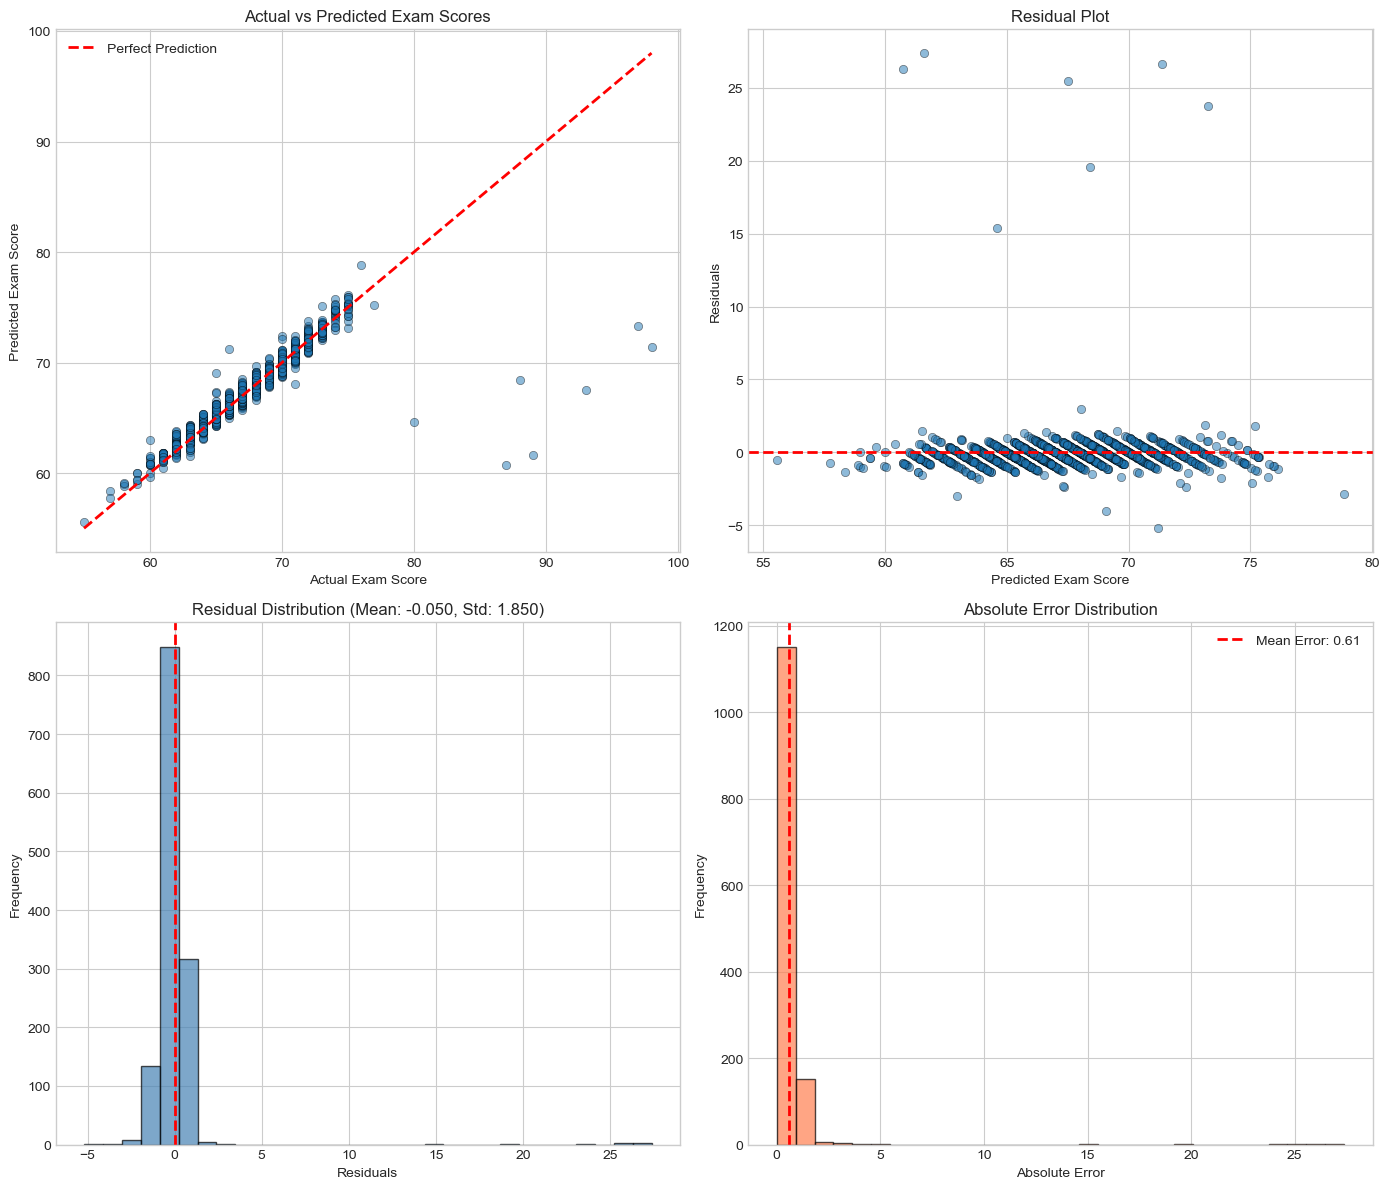

In [21]:
# Final predictions
y_pred_final = best_model.predict(X_test)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y_test, y_pred_final, alpha=0.5, edgecolors='k', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Exam Score')
ax1.set_ylabel('Predicted Exam Score')
ax1.set_title('Actual vs Predicted Exam Scores')
ax1.legend()

# 2. Residual plot
ax2 = axes[0, 1]
residuals = y_test - y_pred_final
ax2.scatter(y_pred_final, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Exam Score')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')

# 3. Residual distribution
ax3 = axes[1, 0]
ax3.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.set_title(f'Residual Distribution (Mean: {residuals.mean():.3f}, Std: {residuals.std():.3f})')

# 4. Prediction error distribution
ax4 = axes[1, 1]
errors = np.abs(residuals)
ax4.hist(errors, bins=30, edgecolor='black', alpha=0.7, color='coral')
ax4.axvline(x=errors.mean(), color='r', linestyle='--', lw=2, label=f'Mean Error: {errors.mean():.2f}')
ax4.set_xlabel('Absolute Error')
ax4.set_ylabel('Frequency')
ax4.set_title('Absolute Error Distribution')
ax4.legend()

plt.tight_layout()
plt.show()

In [22]:
# Final Summary
print("="*70)
print("FINAL MODEL SUMMARY")
print("="*70)

print("\n📊 Model Configuration:")
print("-"*70)
for param, value in grid_search_fine.best_params_.items():
    print(f"  {param}: {value}")

print("\n📈 Final Test Set Performance:")
print("-"*70)
final_r2 = r2_score(y_test, y_pred_final)
final_mae = mean_absolute_error(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))

print(f"  R² Score:  {final_r2:.4f}")
print(f"  MAE:       {final_mae:.4f}")
print(f"  RMSE:      {final_rmse:.4f}")

print("\n📉 Cross-Validation Performance (5-Fold):")
print("-"*70)
print(f"  R² Score:  {cv_r2_opt.mean():.4f} (+/- {cv_r2_opt.std() * 2:.4f})")
print(f"  MAE:       {-cv_neg_mae_opt.mean():.4f} (+/- {cv_neg_mae_opt.std() * 2:.4f})")
print(f"  RMSE:      {-cv_neg_rmse_opt.mean():.4f} (+/- {cv_neg_rmse_opt.std() * 2:.4f})")

print("\n🔑 Top 5 Most Important Features:")
print("-"*70)
for i, row in feature_importance.head(5).iterrows():
    print(f"  {feature_importance.head(5).index.tolist().index(i)+1}. {row['Feature']}: {row['Gain']:.4f}")

print("\n" + "="*70)
print("Model training and optimization complete!")
print("="*70)

FINAL MODEL SUMMARY

📊 Model Configuration:
----------------------------------------------------------------------
  colsample_bytree: 0.8
  learning_rate: 0.15000000000000002
  max_depth: 2
  min_child_weight: 3
  n_estimators: 200
  reg_alpha: 0.5
  reg_lambda: 2
  subsample: 0.8

📈 Final Test Set Performance:
----------------------------------------------------------------------
  R² Score:  0.7578
  MAE:       0.6139
  RMSE:      1.8501

📉 Cross-Validation Performance (5-Fold):
----------------------------------------------------------------------
  R² Score:  0.7229 (+/- 0.2017)
  MAE:       0.6332 (+/- 0.1113)
  RMSE:      2.0282 (+/- 1.0336)

🔑 Top 5 Most Important Features:
----------------------------------------------------------------------
  1. Attendance: 0.3563
  2. Hours_Studied: 0.1042
  3. Access_to_Resources: 0.0790
  4. Parental_Involvement: 0.0716
  5. Previous_Scores: 0.0546

Model training and optimization complete!


## 8. Advanced Feature Engineering for Improved Performance

Based on our analysis, we'll create:
1. **Interaction features** between top predictors
2. **Composite scores** representing student support and effort
3. **Handle outliers** that affect model performance

In [23]:
# Start with a fresh copy of processed data
df_enhanced = df_processed.copy()

# 1. INTERACTION FEATURES (between top predictors)
print("Creating interaction features...")

# Attendance × Hours_Studied (study effectiveness when present)
df_enhanced['Attendance_x_Hours'] = df_enhanced['Attendance'] * df_enhanced['Hours_Studied']

# Previous_Scores × Attendance (consistent high performers)
df_enhanced['PrevScore_x_Attendance'] = df_enhanced['Previous_Scores'] * df_enhanced['Attendance']

# Hours_Studied × Tutoring_Sessions (total structured learning)
df_enhanced['Hours_x_Tutoring'] = df_enhanced['Hours_Studied'] * df_enhanced['Tutoring_Sessions']

# Parental_Involvement × Access_to_Resources (support ecosystem)
df_enhanced['ParentInv_x_Resources'] = df_enhanced['Parental_Involvement'] * df_enhanced['Access_to_Resources']

# Motivation × Hours_Studied (motivated study time)
df_enhanced['Motivation_x_Hours'] = df_enhanced['Motivation_Level'] * df_enhanced['Hours_Studied']

# 2. COMPOSITE SCORES
print("Creating composite scores...")

# Support Index (environmental factors)
df_enhanced['Support_Index'] = (
    df_enhanced['Parental_Involvement'] + 
    df_enhanced['Access_to_Resources'] + 
    df_enhanced['Teacher_Quality'] + 
    df_enhanced['Family_Income']
) / 4

# Effort Score (student's own effort)
df_enhanced['Effort_Score'] = (
    df_enhanced['Hours_Studied'] / df_enhanced['Hours_Studied'].max() +
    df_enhanced['Attendance'] / 100 +
    df_enhanced['Tutoring_Sessions'] / df_enhanced['Tutoring_Sessions'].max() +
    df_enhanced['Motivation_Level'] / 2
) / 4

# Academic Readiness (prior preparation)
df_enhanced['Academic_Readiness'] = (
    df_enhanced['Previous_Scores'] / 100 +
    df_enhanced['Parental_Education_Level'] / 2
) / 2

# 3. POLYNOMIAL FEATURES for top 2 predictors
print("Creating polynomial features...")
df_enhanced['Attendance_squared'] = df_enhanced['Attendance'] ** 2
df_enhanced['Hours_squared'] = df_enhanced['Hours_Studied'] ** 2

# 4. RATIO FEATURES
print("Creating ratio features...")
# Study efficiency (hours per tutoring support)
df_enhanced['Study_Efficiency'] = df_enhanced['Hours_Studied'] / (df_enhanced['Tutoring_Sessions'] + 1)

# Learning intensity
df_enhanced['Learning_Intensity'] = (df_enhanced['Hours_Studied'] + df_enhanced['Tutoring_Sessions'] * 2) / (11 - df_enhanced['Sleep_Hours'])

print(f"\nNew features created: {df_enhanced.shape[1] - df_processed.shape[1]}")
print(f"Total features now: {df_enhanced.shape[1] - 1}")  # -1 for target

# Display new features
new_features = [col for col in df_enhanced.columns if col not in df_processed.columns]
print(f"\nNew feature names: {new_features}")

Creating interaction features...
Creating composite scores...
Creating polynomial features...
Creating ratio features...

New features created: 12
Total features now: 31

New feature names: ['Attendance_x_Hours', 'PrevScore_x_Attendance', 'Hours_x_Tutoring', 'ParentInv_x_Resources', 'Motivation_x_Hours', 'Support_Index', 'Effort_Score', 'Academic_Readiness', 'Attendance_squared', 'Hours_squared', 'Study_Efficiency', 'Learning_Intensity']


Analyzing outliers in target variable...
Q1: 65.0, Q3: 69.0, IQR: 4.0
Outlier bounds: [59.00, 75.00]

Number of outliers: 104 (1.57%)


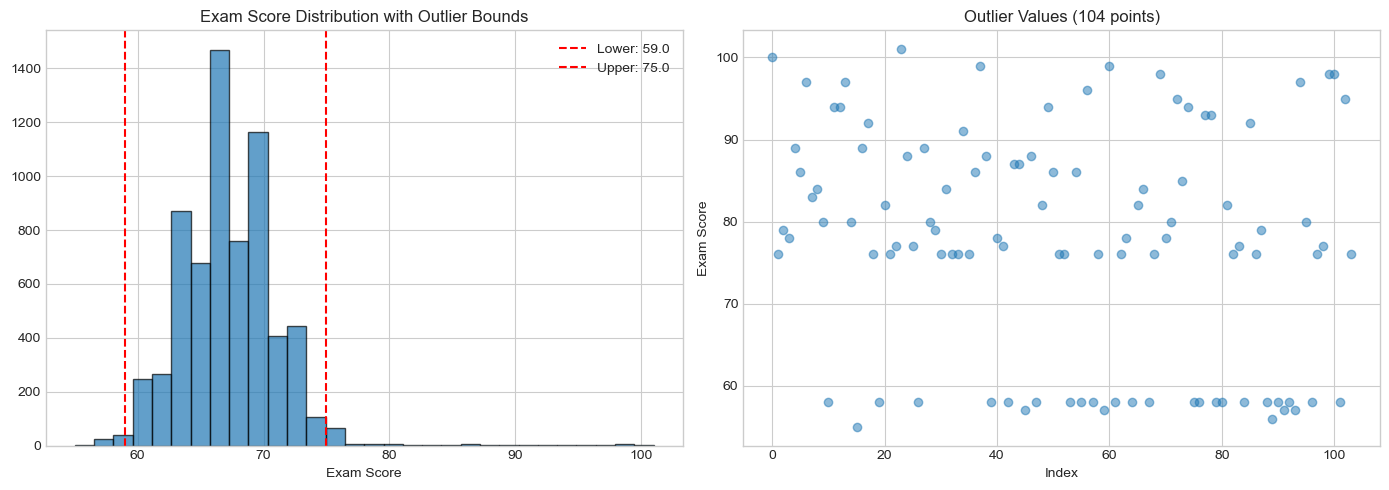


Dataset size after removing outliers: 6503 (removed 104)


In [24]:
# Analyze and handle outliers
print("Analyzing outliers in target variable...")

# Calculate IQR for outlier detection
Q1 = df_enhanced['Exam_Score'].quantile(0.25)
Q3 = df_enhanced['Exam_Score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Count outliers
outliers = df_enhanced[(df_enhanced['Exam_Score'] < lower_bound) | (df_enhanced['Exam_Score'] > upper_bound)]
print(f"\nNumber of outliers: {len(outliers)} ({len(outliers)/len(df_enhanced)*100:.2f}%)")

# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before removing outliers
axes[0].hist(df_enhanced['Exam_Score'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(lower_bound, color='red', linestyle='--', label=f'Lower: {lower_bound:.1f}')
axes[0].axvline(upper_bound, color='red', linestyle='--', label=f'Upper: {upper_bound:.1f}')
axes[0].set_title('Exam Score Distribution with Outlier Bounds')
axes[0].set_xlabel('Exam Score')
axes[0].legend()

# Show outlier distribution
axes[1].scatter(range(len(outliers)), outliers['Exam_Score'], alpha=0.5)
axes[1].set_title(f'Outlier Values ({len(outliers)} points)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Exam Score')

plt.tight_layout()
plt.show()

# Create dataset without outliers
df_no_outliers = df_enhanced[(df_enhanced['Exam_Score'] >= lower_bound) & (df_enhanced['Exam_Score'] <= upper_bound)]
print(f"\nDataset size after removing outliers: {len(df_no_outliers)} (removed {len(df_enhanced) - len(df_no_outliers)})")

In [25]:
# Prepare enhanced features for training
X_enhanced = df_enhanced.drop('Exam_Score', axis=1)
y_enhanced = df_enhanced['Exam_Score']

# Split with same random state for fair comparison
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

print(f"Enhanced dataset shapes:")
print(f"  Training: {X_train_enh.shape}")
print(f"  Test: {X_test_enh.shape}")
print(f"  Features: {X_train_enh.shape[1]}")

Enhanced dataset shapes:
  Training: (5285, 31)
  Test: (1322, 31)
  Features: 31


## 9. Train Improved Model with Enhanced Features

Using early stopping, more estimators, and the engineered features.

In [26]:
# Train model with enhanced features using early stopping
print("Training XGBoost with enhanced features and early stopping...")

# Start with best params from previous tuning, but allow more estimators
enhanced_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,  # More estimators with early stopping
    max_depth=3,
    learning_rate=0.05,  # Lower learning rate for better generalization
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

# Fit with early stopping
enhanced_model.fit(
    X_train_enh, y_train_enh,
    eval_set=[(X_test_enh, y_test_enh)],
    verbose=False
)

print(f"Best iteration: {enhanced_model.best_iteration}")

# Evaluate
enhanced_metrics, enhanced_pred = evaluate_model(
    enhanced_model, X_train_enh, X_test_enh, y_train_enh, y_test_enh,
    "Enhanced Features XGBoost"
)

Training XGBoost with enhanced features and early stopping...
Best iteration: 236

Enhanced Features XGBoost Performance Metrics

Metric          Train           Test           
---------------------------------------------
R²              0.7650          0.7525         
MAE             0.6273          0.6568         
RMSE            1.9011          1.8705         


In [27]:
# Fine-tune the enhanced model
print("Fine-tuning enhanced model...")

param_grid_enhanced = {
    'n_estimators': [200, 300, 500],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.03, 0.05, 0.08],
    'min_child_weight': [2, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [1, 2, 3]
}

# Use RandomizedSearchCV for faster search with many params
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_distributions=param_grid_enhanced,
    n_iter=100,  # Try 100 random combinations
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_enh, y_train_enh)

print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV RMSE: {-random_search.best_score_:.4f}")

Fine-tuning enhanced model...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found:
  subsample: 0.8
  reg_lambda: 3
  reg_alpha: 1.0
  n_estimators: 300
  min_child_weight: 5
  max_depth: 2
  learning_rate: 0.08
  colsample_bytree: 0.9

Best CV RMSE: 2.1127


In [28]:
# Evaluate the best enhanced model
best_enhanced_model = random_search.best_estimator_

best_enhanced_metrics, best_enhanced_pred = evaluate_model(
    best_enhanced_model, X_train_enh, X_test_enh, y_train_enh, y_test_enh,
    "Best Enhanced XGBoost"
)

# Cross-validation on enhanced model
cv_r2_enhanced = cross_val_score(best_enhanced_model, X_enhanced, y_enhanced, cv=kfold, scoring='r2')
cv_mae_enhanced = cross_val_score(best_enhanced_model, X_enhanced, y_enhanced, cv=kfold, scoring='neg_mean_absolute_error')
cv_rmse_enhanced = cross_val_score(best_enhanced_model, X_enhanced, y_enhanced, cv=kfold, scoring='neg_root_mean_squared_error')

print("\n5-Fold Cross-Validation (Enhanced Model):")
print("="*50)
print(f"R²:   {cv_r2_enhanced.mean():.4f} (+/- {cv_r2_enhanced.std() * 2:.4f})")
print(f"MAE:  {-cv_mae_enhanced.mean():.4f} (+/- {cv_mae_enhanced.std() * 2:.4f})")
print(f"RMSE: {-cv_rmse_enhanced.mean():.4f} (+/- {cv_rmse_enhanced.std() * 2:.4f})")


Best Enhanced XGBoost Performance Metrics

Metric          Train           Test           
---------------------------------------------
R²              0.7456          0.7558         
MAE             0.6117          0.6163         
RMSE            1.9783          1.8581         

5-Fold Cross-Validation (Enhanced Model):
R²:   0.7226 (+/- 0.1956)
MAE:  0.6501 (+/- 0.1048)
RMSE: 2.0313 (+/- 1.0094)


COMPREHENSIVE MODEL COMPARISON


               Model  Test R²  Test MAE  Test RMSE  CV R² Mean  CV RMSE Mean
            Baseline 0.649407  0.986448   2.226129    0.641204      2.325575
Optimized (Original) 0.757841  0.613856   1.850119    0.722921      2.028196
   Enhanced Features 0.755757  0.616330   1.858061    0.722601      2.031252


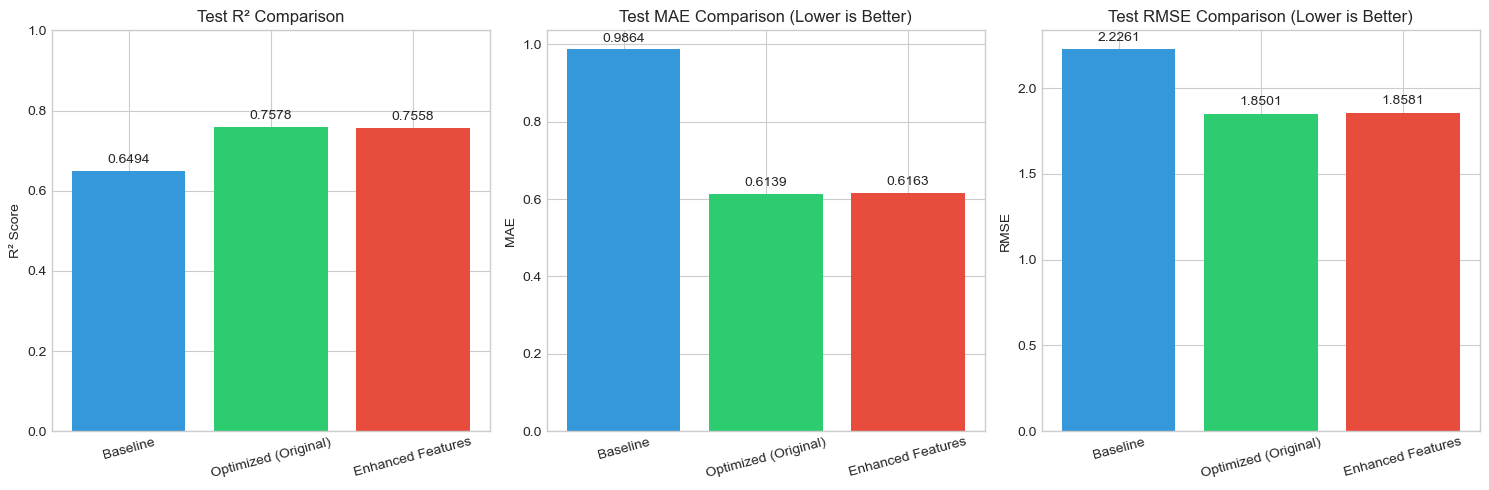


IMPROVEMENT SUMMARY

Enhanced vs Baseline:
  R² improvement:   +10.63%
  MAE reduction:    +0.3701
  RMSE reduction:   +0.3681

Enhanced vs Previous Best (Optimized):
  R² improvement:   -0.21%
  MAE reduction:    -0.0025
  RMSE reduction:   -0.0079


In [29]:
# Compare all models
print("="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

comparison_data = {
    'Model': ['Baseline', 'Optimized (Original)', 'Enhanced Features'],
    'Test R²': [baseline_metrics['Test R²'], optimized_metrics['Test R²'], best_enhanced_metrics['Test R²']],
    'Test MAE': [baseline_metrics['Test MAE'], optimized_metrics['Test MAE'], best_enhanced_metrics['Test MAE']],
    'Test RMSE': [baseline_metrics['Test RMSE'], optimized_metrics['Test RMSE'], best_enhanced_metrics['Test RMSE']],
    'CV R² Mean': [cv_r2.mean(), cv_r2_opt.mean(), cv_r2_enhanced.mean()],
    'CV RMSE Mean': [-cv_neg_rmse.mean(), -cv_neg_rmse_opt.mean(), -cv_rmse_enhanced.mean()]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = comparison_data['Model']
x = np.arange(len(models))

# R² comparison
axes[0].bar(x, comparison_data['Test R²'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0].set_ylabel('R² Score')
axes[0].set_title('Test R² Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15)
axes[0].set_ylim(0, 1)
for i, v in enumerate(comparison_data['Test R²']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)

# MAE comparison
axes[1].bar(x, comparison_data['Test MAE'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1].set_ylabel('MAE')
axes[1].set_title('Test MAE Comparison (Lower is Better)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=15)
for i, v in enumerate(comparison_data['Test MAE']):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)

# RMSE comparison
axes[2].bar(x, comparison_data['Test RMSE'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[2].set_ylabel('RMSE')
axes[2].set_title('Test RMSE Comparison (Lower is Better)')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models, rotation=15)
for i, v in enumerate(comparison_data['Test RMSE']):
    axes[2].text(i, v + 0.05, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Calculate improvements
print("\n" + "="*70)
print("IMPROVEMENT SUMMARY")
print("="*70)
print(f"\nEnhanced vs Baseline:")
print(f"  R² improvement:   {(best_enhanced_metrics['Test R²'] - baseline_metrics['Test R²'])*100:+.2f}%")
print(f"  MAE reduction:    {(baseline_metrics['Test MAE'] - best_enhanced_metrics['Test MAE']):+.4f}")
print(f"  RMSE reduction:   {(baseline_metrics['Test RMSE'] - best_enhanced_metrics['Test RMSE']):+.4f}")

print(f"\nEnhanced vs Previous Best (Optimized):")
print(f"  R² improvement:   {(best_enhanced_metrics['Test R²'] - optimized_metrics['Test R²'])*100:+.2f}%")
print(f"  MAE reduction:    {(optimized_metrics['Test MAE'] - best_enhanced_metrics['Test MAE']):+.4f}")
print(f"  RMSE reduction:   {(optimized_metrics['Test RMSE'] - best_enhanced_metrics['Test RMSE']):+.4f}")

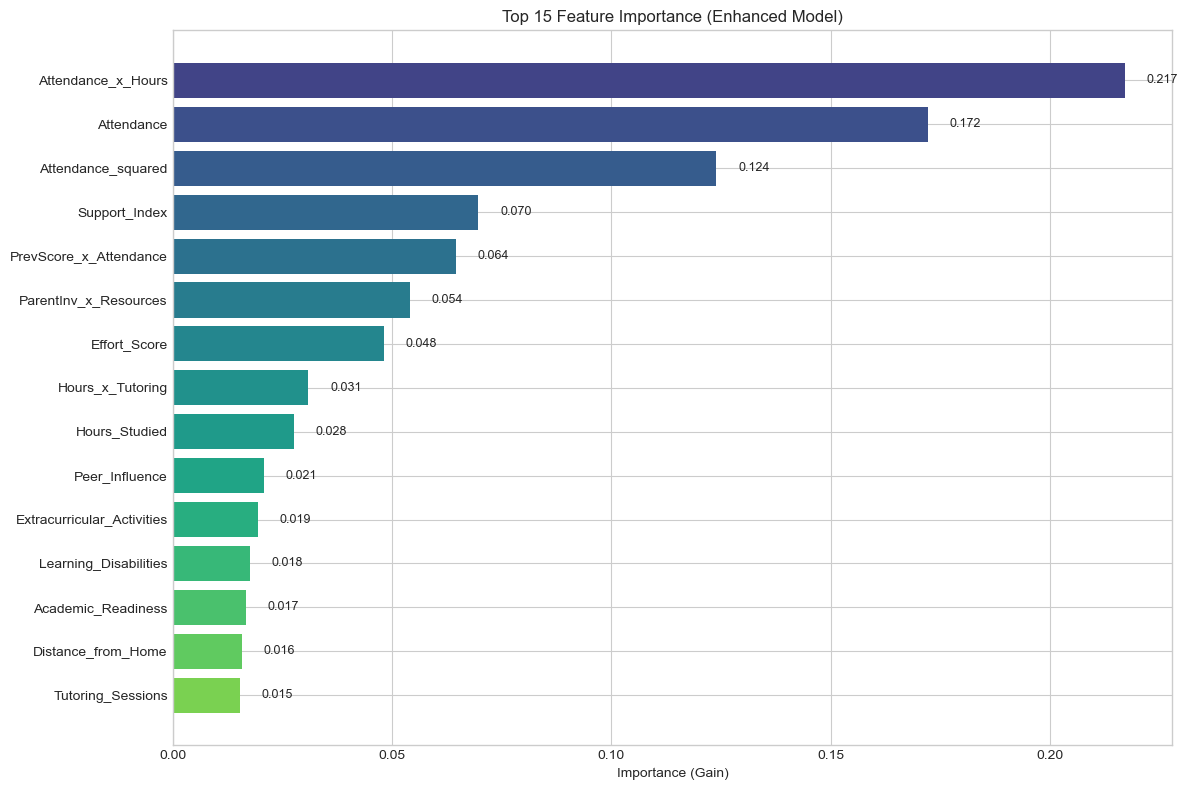


New Engineered Features in Top 15:
--------------------------------------------------
  Attendance_x_Hours: 0.2171
  Attendance_squared: 0.1239
  Support_Index: 0.0697
  PrevScore_x_Attendance: 0.0645
  ParentInv_x_Resources: 0.0540
  Effort_Score: 0.0482
  Hours_x_Tutoring: 0.0309
  Academic_Readiness: 0.0166


In [30]:
# Feature importance for enhanced model
enhanced_feature_importance = pd.DataFrame({
    'Feature': X_enhanced.columns,
    'Gain': best_enhanced_model.feature_importances_
}).sort_values('Gain', ascending=False)

# Plot top 15 features
fig, ax = plt.subplots(figsize=(12, 8))
top_n = 15
colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))
bars = ax.barh(enhanced_feature_importance['Feature'].head(top_n), 
               enhanced_feature_importance['Gain'].head(top_n), 
               color=colors)
ax.set_xlabel('Importance (Gain)')
ax.set_title(f'Top {top_n} Feature Importance (Enhanced Model)')
ax.invert_yaxis()

for bar, val in zip(bars, enhanced_feature_importance['Gain'].head(top_n)):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Show which new features are important
print("\nNew Engineered Features in Top 15:")
print("-"*50)
new_in_top = enhanced_feature_importance.head(top_n)
new_in_top = new_in_top[new_in_top['Feature'].isin(new_features)]
if len(new_in_top) > 0:
    for _, row in new_in_top.iterrows():
        print(f"  {row['Feature']}: {row['Gain']:.4f}")
else:
    print("  None of the new features made it to top 15")

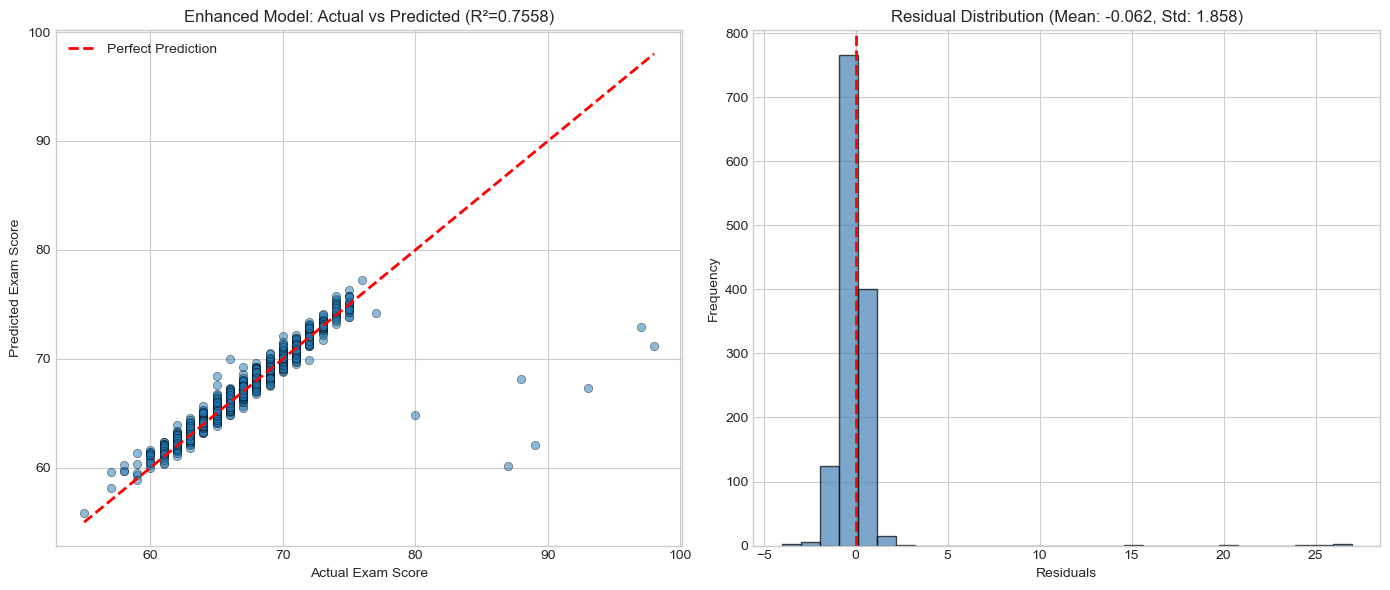


FINAL ENHANCED MODEL SUMMARY

📊 Best Model Configuration:
   subsample: 0.8
   reg_lambda: 3
   reg_alpha: 1.0
   n_estimators: 300
   min_child_weight: 5
   max_depth: 2
   learning_rate: 0.08
   colsample_bytree: 0.9

📈 Final Performance Metrics:
   Test R²:  0.7558
   Test MAE: 0.6163
   Test RMSE: 1.8581

📉 Cross-Validation Performance:
   CV R²:   0.7226 (+/- 0.1956)
   CV MAE:  0.6501 (+/- 0.1048)
   CV RMSE: 2.0313 (+/- 1.0094)

🔑 Top 5 Features:
   1. Attendance_x_Hours: 0.2171
   2. Attendance: 0.1722
   3. Attendance_squared: 0.1239
   4. Support_Index: 0.0697
   5. PrevScore_x_Attendance: 0.0645



In [31]:
# Final visualization: Actual vs Predicted for enhanced model
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Actual vs Predicted
axes[0].scatter(y_test_enh, best_enhanced_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test_enh.min(), y_test_enh.max()], [y_test_enh.min(), y_test_enh.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Exam Score')
axes[0].set_ylabel('Predicted Exam Score')
axes[0].set_title(f'Enhanced Model: Actual vs Predicted (R²={best_enhanced_metrics["Test R²"]:.4f})')
axes[0].legend()

# Residual distribution
residuals_enhanced = y_test_enh - best_enhanced_pred
axes[1].hist(residuals_enhanced, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Residual Distribution (Mean: {residuals_enhanced.mean():.3f}, Std: {residuals_enhanced.std():.3f})')

plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*70)
print("FINAL ENHANCED MODEL SUMMARY")
print("="*70)
print(f"\n📊 Best Model Configuration:")
for param, value in random_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📈 Final Performance Metrics:")
print(f"   Test R²:  {best_enhanced_metrics['Test R²']:.4f}")
print(f"   Test MAE: {best_enhanced_metrics['Test MAE']:.4f}")
print(f"   Test RMSE: {best_enhanced_metrics['Test RMSE']:.4f}")

print(f"\n📉 Cross-Validation Performance:")
print(f"   CV R²:   {cv_r2_enhanced.mean():.4f} (+/- {cv_r2_enhanced.std() * 2:.4f})")
print(f"   CV MAE:  {-cv_mae_enhanced.mean():.4f} (+/- {cv_mae_enhanced.std() * 2:.4f})")
print(f"   CV RMSE: {-cv_rmse_enhanced.mean():.4f} (+/- {cv_rmse_enhanced.std() * 2:.4f})")

print(f"\n🔑 Top 5 Features:")
for i, row in enhanced_feature_importance.head(5).iterrows():
    rank = enhanced_feature_importance.head(5).index.tolist().index(i) + 1
    print(f"   {rank}. {row['Feature']}: {row['Gain']:.4f}")

print("\n" + "="*70)